# Link Prediction Lab

In [1]:
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt
import random as rnd

rnd.seed()

## Graph Input

In [2]:
G = nx.read_edgelist("karate")

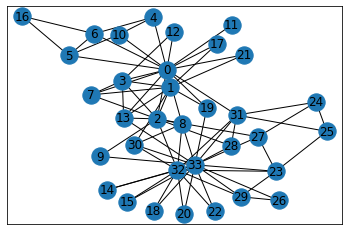

In [4]:
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G,pos, with_labels=True)
plt.show()

## Computing Common Neighbors Score

We define the "common neighbours" link score:

In [5]:
def common_neighbors(G,i,j):
    # G - the graph
    # i,j - the link
    return len(set(G.neighbors(i)) and set(G.neighbors(j)))

In [6]:
common_neighbors(G,'31','17')

2

## Link Prediction

We define a function which returns a sorted list of of scores from a node to other possible nodes in the graph:

In [75]:
def link_list(G,i,score_func):
    # G - the graph
    # i - the node
    # score_func - the link scoring function, having the signature score_func(G,i,j)
    links = []
    for j in G.nodes():
        if not G.has_edge(i,j) and i!=j:
            e = (i,j)
            sc = score_func(G,i,j)
            links.append([e,sc])
    links.sort(key = lambda x: x[1], reverse = True) 
    return links

In [76]:
link_list(G,'31',common_neighbors)

[[('31', '2'), 10],
 [('31', '1'), 9],
 [('31', '3'), 6],
 [('31', '13'), 5],
 [('31', '8'), 5],
 [('31', '23'), 5],
 [('31', '7'), 4],
 [('31', '6'), 4],
 [('31', '5'), 4],
 [('31', '30'), 4],
 [('31', '27'), 4],
 [('31', '29'), 4],
 [('31', '19'), 3],
 [('31', '10'), 3],
 [('31', '4'), 3],
 [('31', '21'), 2],
 [('31', '17'), 2],
 [('31', '12'), 2],
 [('31', '9'), 2],
 [('31', '16'), 2],
 [('31', '14'), 2],
 [('31', '15'), 2],
 [('31', '18'), 2],
 [('31', '20'), 2],
 [('31', '22'), 2],
 [('31', '26'), 2],
 [('31', '11'), 1]]

### scoring function

In [69]:
# jacard coeff
def jacard_coeff_score(G,i,j):
    # G - the graph
    # i,j - the link
    return len(set(G.neighbors(i)).intersection(set(G.neighbors(j))))/len(set(G.neighbors(i)).union(set(G.neighbors(j))))

#preferential attachement
def pref_attachement(G,i,j):
    # G - the graph
    # i,j - the link
    return nx.degree(G, nbunch=i, weight=None)*nx.degree(G, nbunch=j, weight=None)

# distance score
def inverse_distance_score(G,i,j):
    # G - the graph
    # i,j - the link
    return 1/nx.shortest_path_length(G, source=i, target=j, weight=None, method='dijkstra')

#page rank approche personelized i
def page_rank_score_b(G,i,j):
    # G - the graph
    # i,j - the link
    personal = {i:0 for i in G.nodes()}
    personal[i] = 1

    return nx.pagerank(G, alpha=0.2, personalization=personal, max_iter=100, tol=1e-06, weight='weight', dangling=None)[j]

#page rank topic sensetive i & j /2
def page_rank_score_a(G,i,j):
    # G - the graph
    # i,j - the link
    personal = {i:0 for i in G.nodes()}
    personal[i] = 0.5
    personal[j] = 0.5
    
    return (nx.pagerank(G, alpha=0.2, personalization=personal, max_iter=100, tol=1e-06, weight='weight', dangling=None)[j]+
nx.pagerank(G, alpha=0.2, personalization=personal, max_iter=100, tol=1e-06, weight='weight', dangling=None)[j])/2

def random_score(G,i,j):
    # G - the graph
    # i,j - the link
    return rnd.random()

In [70]:
print(jacard_coeff_score(G,'33','32'))
inverse_distance_score(G,'20','26')

0.5263157894736842


0.5

In [58]:
page_rank_score_a(G,'31','30')

0.4023434475116328

In [61]:
page_rank_score_b(G,'31','30')

0.0008855877122513162

## 3 - Link prediction

In [81]:
def link_prediction(G,k,i,ascore_func):
    ls = link_list(G,i,ascore_func)
    perdiction = ls[0:k]
    links = [i[0] for i in perdiction]
    print(links)

In [84]:
link_prediction(G,3,'31',page_rank_score_a)

[('31', '6'), ('31', '5'), ('31', '2')]
